In [63]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim

import pandas as pd
plt.rcParams.update({'font.size': 22})
pd.set_option('display.float_format', lambda x: '%.2e' % x)

In [13]:
def create_inputfile() :
    inputfile = fp.load_calibration_default()
    inputfile["magnetic_field"]["params"] = mag.select("guenter.json")

    scaleR = [1.0,1.0]
    scaleZ = [1.0,1.0]
    inputfile["grid"] = {"Nx" : 32, "Ny" : 32, "Nz": 20, "n": 3,
                         "scaleR" : scaleR, "scaleZ" : scaleZ}
    inputfile["boundary"]["wall"] = {"type" : "none" }
    inputfile["boundary"]["sheath"] = {"type" : "none" }

    inputfile["init"] ={
        "type" : "fields",
        "density": {    
            "type" : "ne",
            "ntilde": {
                "type" : "circle", # secret init condition in Feltor
                "amplitude" : 1.0,
                "posX" : 0.5,
                "posY" : 0.0,
                "sigma" : 0.2,
                "rk4eps" :1e-6,
                "revolutions" : 1,
                "parallel" : "exact-gaussian", # secret non-symmetric init condition
                "sigma_z" : 0.4
            },
            "profile" : {
                "type" : "const",
                "background" : 0.2
            },
            "damping": {
                "type" : "none"
            }
        },
        "potential" : {"type" : "zero_pol"},
        "velocity"  : {"type" : "zero"}, 
        "aparallel" : {"type" : "zero"}
    }
    inputfile["regularization"] = {
        "direction" : "forward",
        "nu_perp_n" : 0,
        "nu_perp_u" : 0,
        "nu_parallel_n" : 0,
        "order" : 2
    }
    inputfile["source"] = {
        "minne" : 0.,
        "type" : "zero"
    }
    inputfile["timestepper"] = {
        "type" : "adaptive",
        "tableau" : "Bogacki-Shampine-4-2-3",
        "rtol" : 1e-7,
        "atol" : 1e-10,
        "output-mode" : "Tend",
        "Tend" : 1e-4 # choose small we do not simulate anything
    }
    inputfile["FCI"]["periodify"] = False
    inputfile["FCI"]["refine"] = [5,5]
    inputfile["FCI"]["interpolation-method"] = "linear"
    inputfile["advection"]= {
        "type"  : "velocity-staggered",
        "slope-limiter" : "none"}
    inputfile["physical"]["tau"] = 1.0
    inputfile["physical"]["viscosity"] = "value"
    inputfile["physical"]["nu_parallel"] = [0,0.1]
    inputfile["flags"] = []
    inputfile["output"] = {
        "type" : "netcdf",
        "inner_loop" : 1,
        "itstp" : 1,
        "maxout" : 0,
        "compression" : [1,1]
    }
    return inputfile


In [3]:
def create_default_config():
    configfile = {
        # for feltordiag
        "n": 3,
        "Npsi": 64,
        "Neta": 640,
        "Kphi": 10,
        "fsa" : "convoluted-toroidal-average",
        # for interpolate in 3d
        "fine-grid-factor" : 2,
        "time-reduction-factor" : 1
    }
    return configfile

config = create_default_config()
with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)

In [64]:
def plot( simfile, name, filename):
    ncin = Dataset( simfile, 'r', format="NETCDF4")
    pp = json.loads(ncin.inputfile)
    gg = pp["grid"]
    fci = pp["FCI"]
    
    print( f"{simfile}")
    print( f"n: {gg['n']}, Nx: {gg['Nx']}, Nz: {gg['Nz']}, mx: {fci['refine'][0]}", end='')
    print( f", method: {fci['interpolation-method']}")
    frows = 1
    fcols = 1
    x = ncin["x"][:]
    y = ncin["y"][:]
    xc = np.kron( np.ones(np.shape(y)),x).reshape( (np.size(y), np.size(x)))
    yc = np.kron( y, np.ones(np.shape(x))).reshape( (np.size(y), np.size(x)))
    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*12,frows*9),dpi= 80, facecolor='w', edgecolor='k')

    im = ax.pcolormesh(xc, yc, ncin[name][0,:,:],
                          vmin = 0.2, vmax = 0.4,
                       cmap="gist_heat_r", shading="gouraud") 
    fig.colorbar(im, ax=ax)
    ax.axis("scaled")
    ax.set_xlabel( "R [m]")
    ax.set_ylabel( "Z [m]")
    plt.savefig( filename)
    plt.show()
    


In [6]:
simulator = simplesim.Manager( executable="./feltor.sh", directory="Averages/data", filetype="nc")
diagnoser = simplesim.Manager( executable="./feltordiag.sh", directory="Averages/diag", filetype="nc")
interpolator = simplesim.Manager( executable ="./feltorplot.sh",
                                  directory="Averages/plot", filetype = "nc")


In [19]:
# First let us generate a plot file to plot a nice 3d picture in paraview
simulationfile = create_inputfile()

simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 200

config = create_default_config()
config["Kphi"] = 10
with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)
    
simfile =  simulator.create( simulationfile)
diagfile = diagnoser.create( simulationfile)
plotfile = interpolator.create( simulationfile)
print(simfile)
# load plot_init_cylinder_3d statefile in paraview

Averages/data/2e1a8fc787723eea83d71ba6aa86ac85127bc616.nc


Averages/data/f2f62c5d6e3bd58152982e5d827d63c211cc63b0.nc
n: 3, Nx: 50, Nz: 20, mx: 5, method: linear


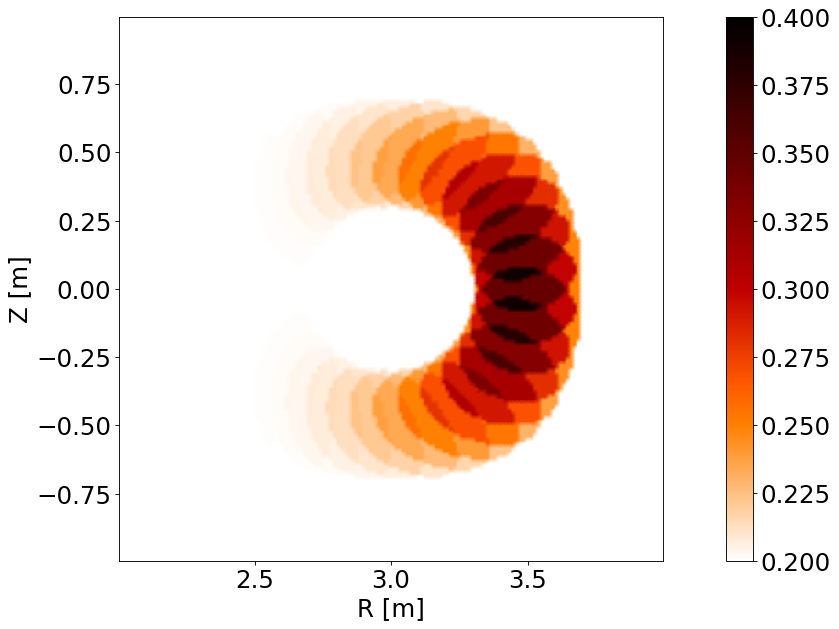

Averages/diag/f2f62c5d6e3bd58152982e5d827d63c211cc63b0.nc
n: 3, Nx: 50, Nz: 20, mx: 5, method: linear


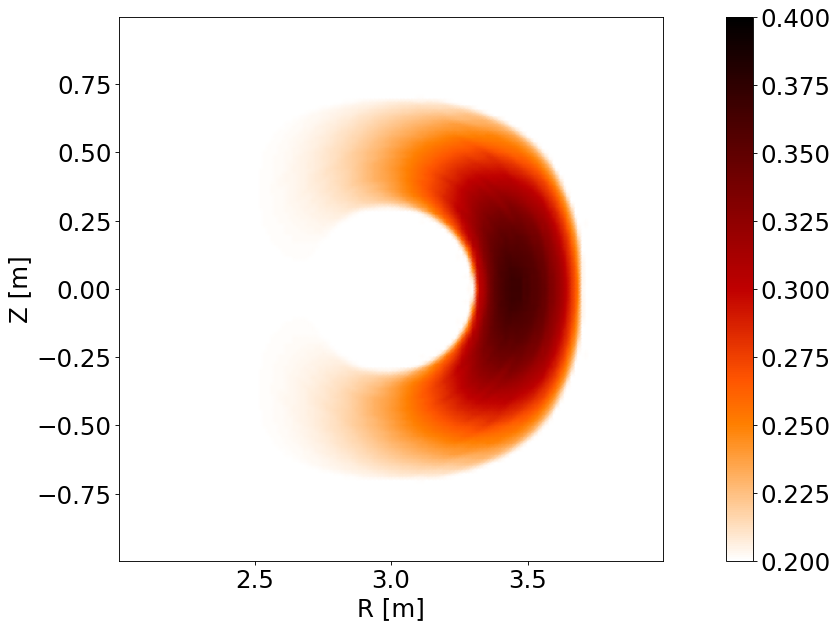

In [65]:
# this is to generate a plot for the average paper
simulationfile = create_inputfile()

simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 20

config = create_default_config()
config["Kphi"] = 10
with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)
    
simfile =  simulator.create( simulationfile)
diagfile = diagnoser.create( simulationfile)
#plotfile = interpolator.create( simulationfile)
plot(simfile, "ions_ta2d", "init-cylinder-ta.png")
plot( diagfile, "ions_cta2d", "init-cylinder-cta10.png")

Averages/data/4fce5780fe964889cc82e020ef62833a18cc60bd.nc
n: 3, Nx: 50, Nz: 20, mx: 5, method: linear


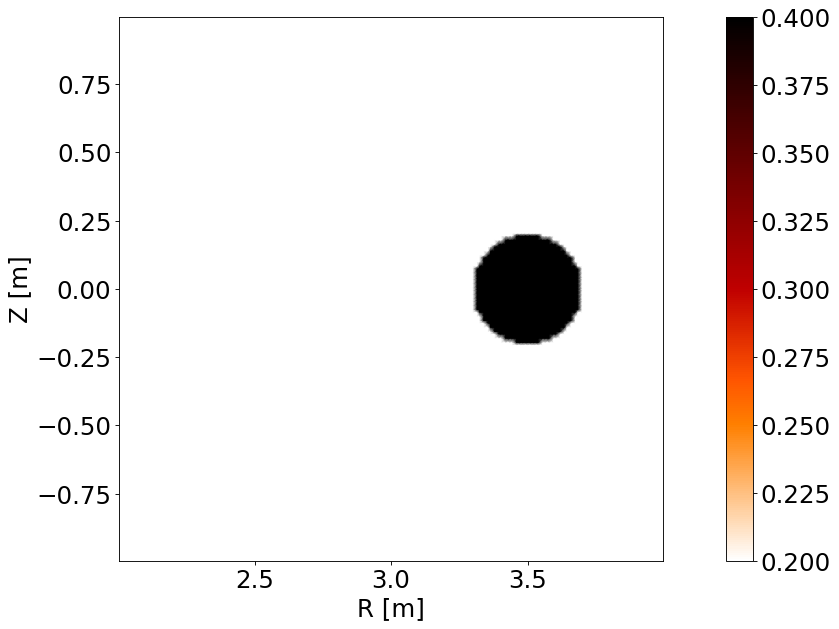

Averages/diag/4fce5780fe964889cc82e020ef62833a18cc60bd.nc
n: 3, Nx: 50, Nz: 20, mx: 5, method: linear


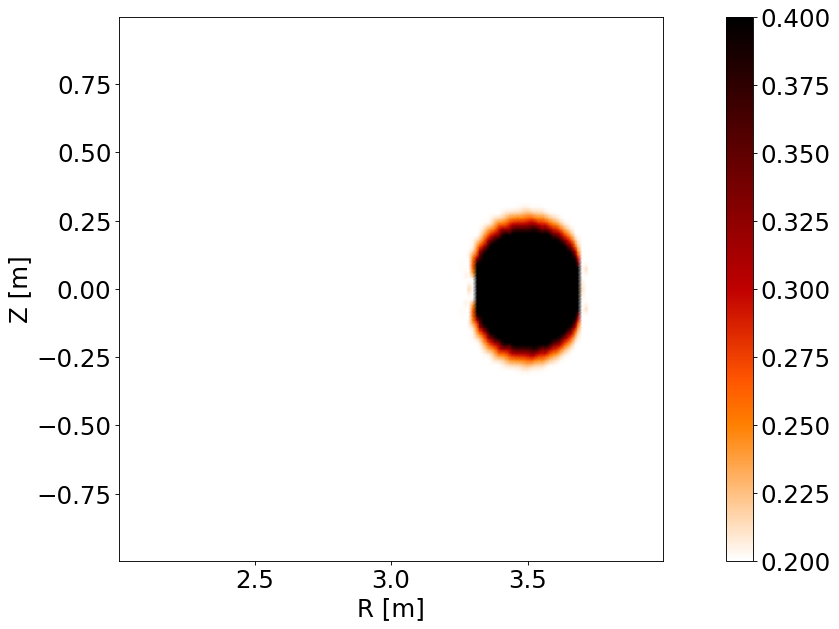

In [66]:
# this is to generate a plot for the average paper
simulationfile = create_inputfile()

simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 20
simulationfile["init"]["density"]["ntilde"]["parallel"] = "toroidal-gaussian"


simfile =  simulator.create( simulationfile)
diagfile = diagnoser.create( simulationfile)
#plotfile = interpolator.create( simulationfile)
plot(simfile, "ions_ta2d", "init-toroidal-ta.png")
plot(diagfile, "ions_cta2d", "init-toroidal-cta10.png")

Averages/diag/f2f62c5d6e3bd58152982e5d827d63c211cc63b0.nc
n: 3, Nx: 50, Nz: 20, mx: 5, method: linear


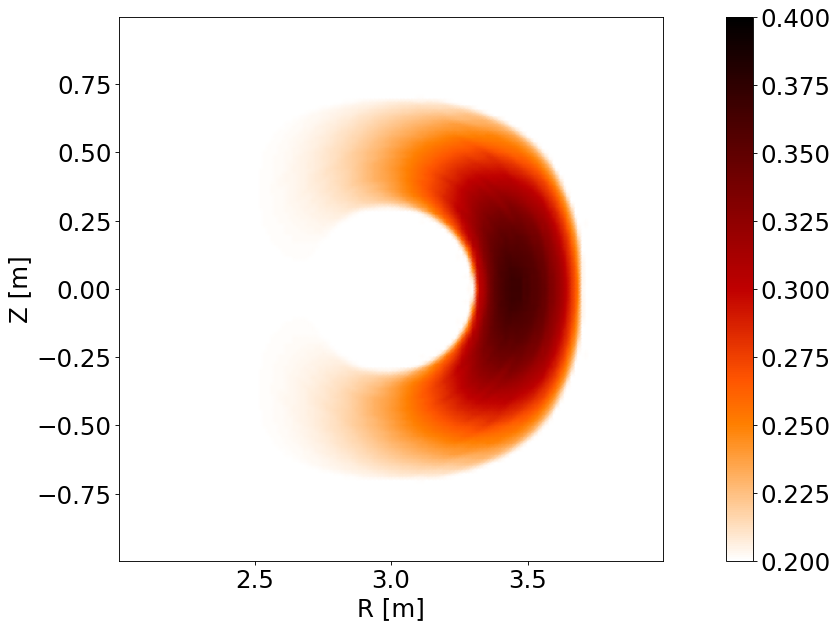

Averages/diag/f2f62c5d6e3bd58152982e5d827d63c211cc63b0.nc
n: 3, Nx: 50, Nz: 20, mx: 5, method: linear


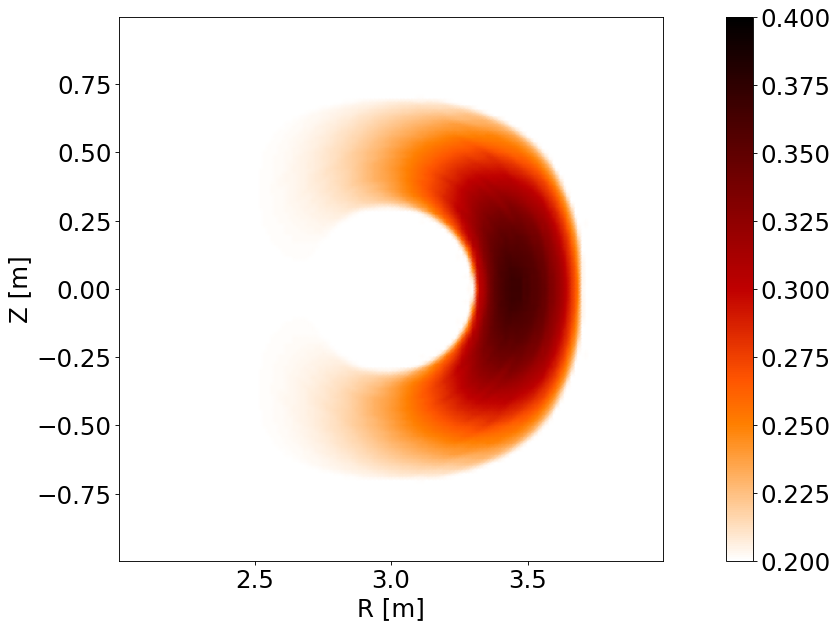

Averages/diag/f2f62c5d6e3bd58152982e5d827d63c211cc63b0.nc
n: 3, Nx: 50, Nz: 20, mx: 5, method: linear


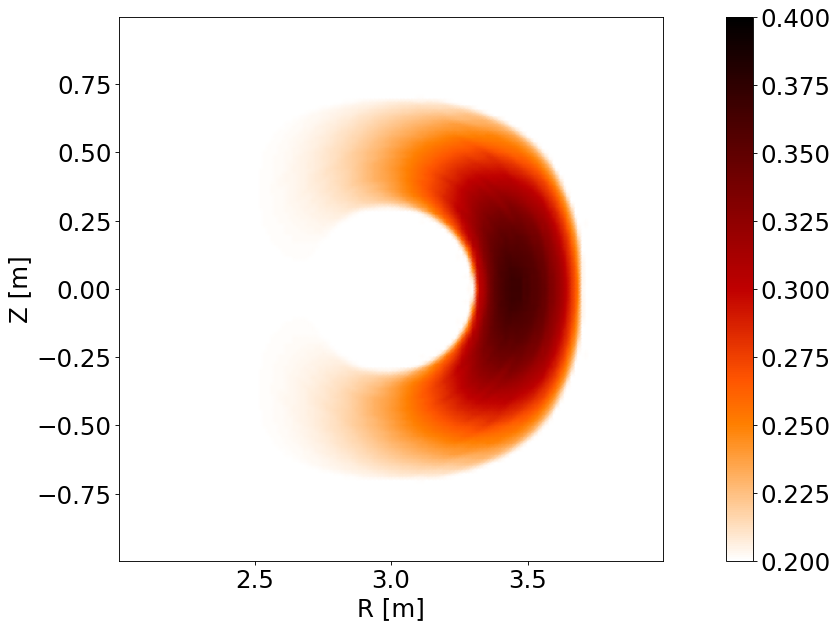

In [67]:
# this is to generate a plot for the average paper
simulationfile = create_inputfile()

simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 20

simfile =  simulator.create( simulationfile)

config = create_default_config()
for Kphi in [2,5,10]:
    config["Kphi"] = Kphi
    with open( "config.json", 'w') as f:
        json.dump( config, f,
            sort_keys=True, ensure_ascii=True, indent=4)
    diagfile = diagnoser.create( simulationfile)

    plot(diagfile, "ions_cta2d", "init-cylinder-cta"+str(Kphi)+".png")

In [21]:
# Construct the Gaussian weights on our grids
def gauss_weights( js) :
    n = js["n"]
    Nx = js["Nx"]
    Ny = js["Ny"]
    lx = 2
    ly = 2
    hx = lx/Nx
    hy = ly/Ny
    (x,w) = np.polynomial.legendre.leggauss(js["n"])
    weights1dX = np.tile( w, js["Nx"])
    weights1dY = np.tile( w, js["Ny"])
    return np.reshape( np.kron( weights1dY, weights1dX)*hy/2.0*hx/2.0 , (js["n"]*js["Ny"], js["n"]*js["Nx"]))

In [22]:
def compare_ta( simfile, bigfile, name1, name2) :
    ncin = Dataset( simfile, 'r', format="NETCDF4")
    bigg = Dataset( bigfile, 'r', format="NETCDF4")
    pp = json.loads(ncin.inputfile)
    gg = pp["grid"]
    fci = pp["FCI"]
    weights = gauss_weights( gg)

    num = ncin[name1][0,:,:]-0.2
    sol = bigg[name2][0,:,:]-0.2
    diff = num - sol
#     norm_diff = np.sqrt(np.sum( diff[:,:]**2*weights ))
    norm_diff = np.max(np.abs(diff))
#     norm_sol = np.sqrt(np.sum( sol[:,:]**2*weights ))
    norm_sol = np.max(np.abs(sol))
    return norm_diff/ norm_sol

In [43]:
#define conversion function 
def orderToString(x): 
    if np.isnan(x) : return 'n/a'
    return'%.2f'% x

def errorToString(x):
    return '%.2e' % x

In [62]:
# Create one big file
lines = list()
for Nphi in [5, 10, 20, 40] :
    simulationfile = create_inputfile()

    simulationfile["grid"]["Nx"] = 50
    simulationfile["grid"]["Ny"] = 50
    simulationfile["grid"]["Nz"] = Nphi
    simulationfile["init"]["density"]["ntilde"]["type"] = "blob"  
    simulationfile["init"]["density"]["ntilde"]["sigma"] = 0.05   
    simulationfile["init"]["density"]["ntilde"]["parallel"] = "exact-gaussian"
    simfile =  simulator.create( simulationfile)
    diagfile = diagnoser.create( simulationfile)
    simulationfile["grid"]["Nz"] = 200
    bigfile = simulator.create( simulationfile)
    bigdiag = diagnoser.create( simulationfile)
    lines.append( [Nphi, compare_ta( simfile, bigfile, "ions_ta2d", "ions_ta2d"),
                  compare_ta( diagfile, bigfile, "ions_cta2d", "ions_ta2d")])

df = pd.DataFrame(lines, columns=["Nz", "error.PAT", "error.PAL"])
for name in ["PAT", "PAL"]:
    df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])
    df["order."+name] = (np.log ( df["order."+name]/ df["order."+name].shift(1))/
        np.log( df["Nz"].shift(1)/df["Nz"]))
df.set_index(['Nz'], inplace=True) 
headers = [ "$\langle f \rangle^T_{\\varphi}$ Eq.~\eqref{eq:pat}",
            "$\langle f \rangle^L_{\\varphi}$ Eq.~\eqref{eq:pal}"
           ]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_fieldaligned_pat.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

$\langle f \rangle^T_{\varphi}$ Eq.~\eqref{eq:pat}         \
                                                error  order   
Nz                                                             
5                                            2.89e+00    n/a   
10                                           9.43e-01   1.61   
20                                           7.71e-02   3.61   
40                                           1.46e-05  12.37   

   $\langle f \rangle^L_{\varphi}$ Eq.~\eqref{eq:pal}        
                                                error order  
Nz                                                           
5                                            7.75e-02   n/a  
10                                           2.32e-02  1.74  
20                                           5.87e-03  1.98  
40                                           2.54e-03  1.21

In [61]:
lines = list()
for Nphi in [5, 10, 20, 40] :
    simulationfile = create_inputfile()
    simulationfile["grid"]["Nx"] = 50
    simulationfile["grid"]["Ny"] = 50
    simulationfile["grid"]["Nz"] = Nphi
    simulationfile["init"]["density"]["ntilde"]["type"] = "blob"   
    simulationfile["init"]["density"]["ntilde"]["parallel"] = "toroidal-gaussian"
    simfile =  simulator.create( simulationfile)
    diagfile = diagnoser.create( simulationfile)
    simulationfile["grid"]["Nz"] = 200
    bigfile = simulator.create( simulationfile)
    bigdiag = diagnoser.create( simulationfile)
    lines.append( [Nphi, compare_ta( simfile, bigfile, "ions_ta2d", "ions_ta2d"),
                  compare_ta( diagfile, bigfile, "ions_cta2d", "ions_ta2d")])
    #plot_ta(simfile)
df = pd.DataFrame(lines, columns=["Nz", "error.PAT", "error.PAL"])
for name in ["PAT", "PAL"]:
    df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])
    df["order."+name] = (np.log ( df["order."+name]/ df["order."+name].shift(1))/
        np.log( df["Nz"].shift(1)/df["Nz"]))
df.set_index(['Nz'], inplace=True) 
headers = [ "$\langle f \rangle^T_{\\varphi}$ Eq.~\eqref{eq:pat}",
            "$\langle f \rangle^L_{\\varphi}$ Eq.~\eqref{eq:pal}"
           ]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_toroidal_pat.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

$\langle f \rangle^T_{\varphi}$ Eq.~\eqref{eq:pat}        \
                                                error order   
Nz                                                            
5                                            3.32e-03   n/a   
10                                           9.00e-04  1.89   
20                                           2.27e-04  1.98   
40                                           5.54e-05  2.04   

   $\langle f \rangle^L_{\varphi}$ Eq.~\eqref{eq:pal}        
                                                error order  
Nz                                                           
5                                            2.99e-01   n/a  
10                                           1.10e-01  1.44  
20                                           3.16e-02  1.80  
40                                           8.22e-03  1.94